In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr


In [2]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [3]:
device = 'gpu'
model_ckpt = 'google/flan-t5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

In [4]:
diasum = load_dataset('knkarthick/dialogsum')
diasum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

In [5]:
diasum['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [6]:
dialogue_len = [len(x['dialogue'].split()) for x in diasum['train']]
summary_len = [len(x['summary'].split()) for x in diasum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

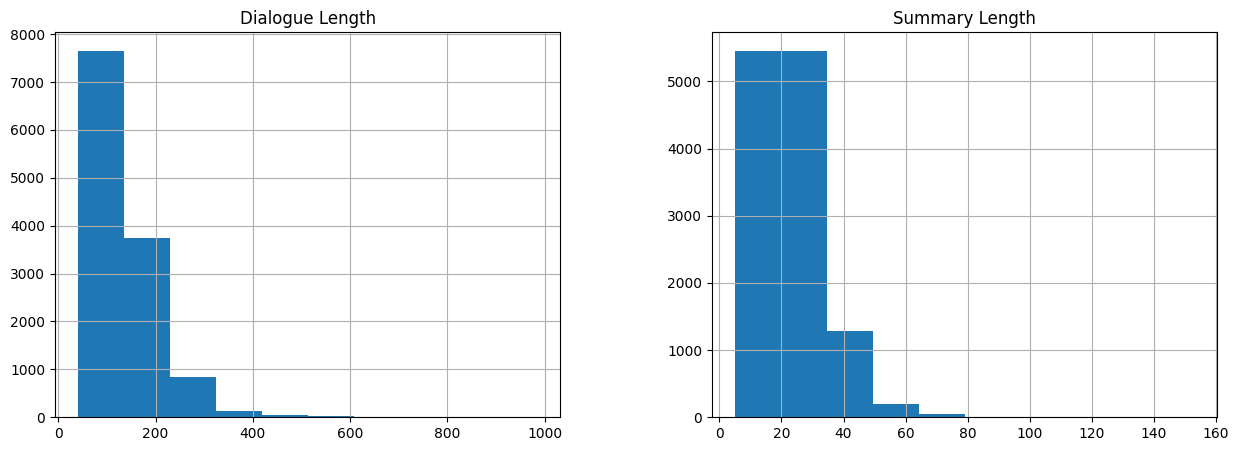

In [7]:

import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))


In [8]:
def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [9]:
diasum_pt = diasum.map(get_feature, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [10]:
diasum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
})

In [11]:
columns = ['input_ids', 'labels', 'attention_mask']
diasum_pt.set_format(type='torch', columns=columns)

In [12]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 't5_diasum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = diasum_pt['train'], eval_dataset = diasum_pt['validation'])

In [14]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=194, training_loss=1.8631878022066097, metrics={'train_runtime': 262.9184, 'train_samples_per_second': 47.391, 'train_steps_per_second': 0.738, 'total_flos': 1529501263626240.0, 'train_loss': 1.8631878022066097, 'epoch': 1.0})

In [15]:
trainer.save_model('t5_diasum_model')

In [16]:
pipe = pipeline('summarization', model='t5_diasum_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

In [17]:
custom_dialogue="#Person1#: Hey Jimmy. Let's go workout later today.\n#Person2#: Sure. What time do you want to go?\n#Person1#: How about at 3:30?\n#Person2#: That sounds good. Today we work on Legs and forearm.\n#Person1#: Hey. I just played basketball earlier, so my legs are a little sore. Let's work out on arms and stomach today.\n#Person2#: I'm on a weekly schedule. You're messing everything up.\n#Person1#: C'mon. We're only switching two days. You can do legs on Friday.\n#Person2#: Aright. I'll meet you at the gym at 3:30 then."
print(pipe(custom_dialogue, **gen_kwargs)[0]['summary_text'])

Jimmy and Jimmy work on Legs and forearm. Jimmy is on a weekly schedule. Jimmy will meet at the gym at 3:30.


In [18]:
!zip t5_sum.zip -r t5_diasum_model/

  adding: t5_diasum_model/ (stored 0%)
  adding: t5_diasum_model/tokenizer_config.json (deflated 95%)
  adding: t5_diasum_model/special_tokens_map.json (deflated 86%)
  adding: t5_diasum_model/config.json (deflated 62%)
  adding: t5_diasum_model/spiece.model (deflated 48%)
  adding: t5_diasum_model/model.safetensors (deflated 7%)
  adding: t5_diasum_model/tokenizer.json (deflated 74%)
  adding: t5_diasum_model/generation_config.json (deflated 29%)
  adding: t5_diasum_model/training_args.bin (deflated 50%)
